# Packages and Functions

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd
import contextily as ctx
import pyproj
import rasterio
from shapely.geometry import Point, LineString, Polygon
from rasterio.transform import Affine
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.plot import show

import os
os.getcwd()

'c:\\Users\\gilramolete\\OneDrive - UNIONBANK of the Philippines\\Documents 1\\Python and ML Learnings with AI COE\\Spatial Programming & Remote Sensing'

# What is a CRS?

Implicit with any GIS data is a **spatial reference system**. It can consist of a simple arbitrary reference system such as a 10 m x 10 m sampling grid in a wood lot or, the boundaries of a soccer field or, it can consist of a geographic reference system, i.e. one where the spatial features are mapped to an earth based reference system. The focus of this topic is on earth reference systems which can be based on a Geographic Coordinate System (GCS) or a Project Coordinate System (PCS).

## Geographic Coordinate Systems

A geographic coordinate system is a **reference system for identifying locations on the curved surface of the earth**. Locations on the earth’s surface are measured in angular units from the center of the earth **relative to two planes**: the plane defined by the **equator** and the plane defined by the **prime meridian** (which crosses Greenwich England). A location is therefore defined by two values: a latitudinal value and a longitudinal value.

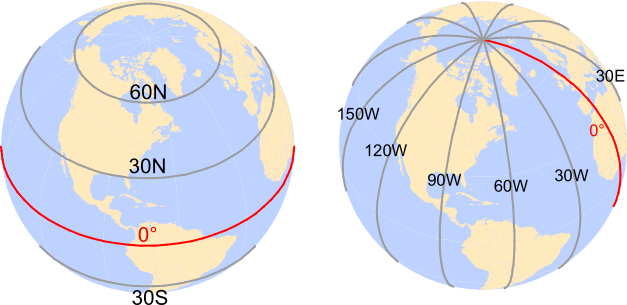

Examples of latitudinal lines are shown on the left and examples of longitudinal lines are shown on the right. The 0° degree reference lines for each are shown in red (equator for latitudinal measurements and prime meridian for longitudinal measurements).

A latitude measures the **angle from the equatorial plane** to the **location on the earth’s surface**. A longitude measures the **angle between the prime meridian plane** and the **north-south plane that intersects the location of interest**. For example, the George Washington University is located at around 38.89° North and -77.04° West. In a GIS system, the North-South and East-West directions are encoded as signs. North and East are assigned a positive (+) sign and South and West are assigned a negative (-) sign. The university location is therefore encoded as +38.89° and -77.04°.

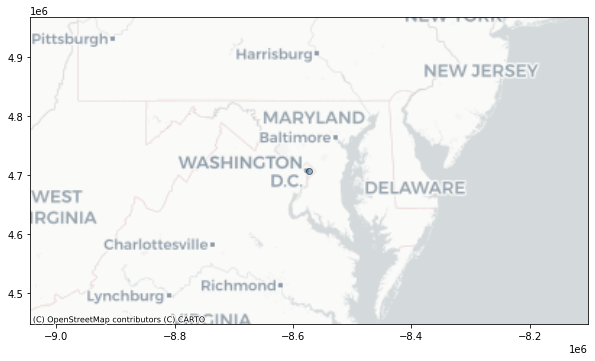

In [2]:
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
cities = cities[cities['name'].str.contains('Washington')]
cities = cities.to_crs(epsg = 3857) # project to webmercator

ax = cities.plot(figsize = (10, 10), alpha = 0.5, edgecolor = 'k')
ctx.add_basemap(ax, source = ctx.providers.CartoDB.Positron, zoom = 6, reset_extent = True) 

A GCS is defined by an **ellipsoid, geoid** and **datum**. These elements are presented next.

### Sphere and Ellipsoid

Assuming that the earth is a perfect sphere greatly simplifies mathematical calculations and works well for small-scale maps (maps that show a large area of the earth). However, when working at larger scales, an ellipsoid representation of earth may be desired if accurate measurements are needed. An ellipsoid is defined by two radii: the **semi-major axis (the equatorial radius)** and the **semi-minor axis (the polar radius)**. The reason the earth has a slightly ellipsoidal shape has to do with its **rotation** which induces a centripetal force along the equator. This results in an equatorial axis that is **roughly 21 km longer** than the polar axis.

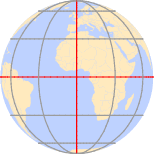 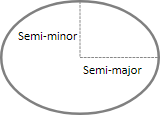

The earth can be mathematically modeled as a simple sphere (left) or an ellipsoid (right). Our estimate of these radii is quite precise thanks to satellite and computational capabilities. The semi-major axis is 6,378,137 meters and the semi-minor axis is 6,356,752 meters.

Differences in distance measurements along the surfaces of an ellipsoid vs. a sphere are small but measurable (the difference can be as high as 20 km) as illustrated in the following lattice plots.

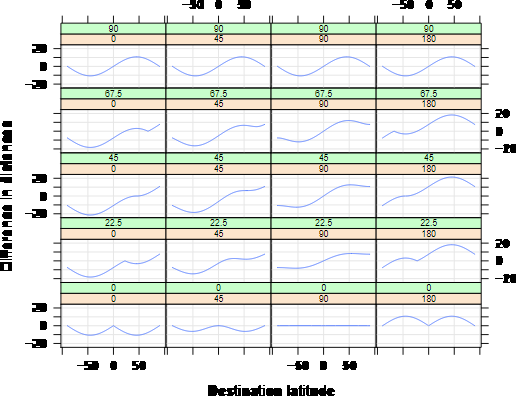

Differences in distance measurements between the surface of a sphere and an ellipsoid. Each graphic plots the differences in distance measurements made from a single point location along the 0&deg; **meridian** identified by the **green colored box (latitude value)** to various latitudinal locations along a **longitude** (whose value is listed in the **bisque colored box**). For example, the second plot from the top-left corner plot shows the differences in distance measurements made from a location at 90&deg; north (along the prime meridian) to a range of latitudinal locations along the 45&deg; meridian.

### Geoid

Representing the earth’s true shape, the geoid, as a mathematical model is crucial for a GIS environment. However, the earth’s shape is not a perfectly smooth surface. It has undulations resulting from changes in gravitational pull across its surface. These undulations may not be visible with the naked eye, but they are measurable and can influence locational measurements. Note that we are not including mountains and ocean bottoms in our discussion, instead we are focusing solely on the **earth’s gravitational potential** which can be best visualized by imagining the earth’s surface completely immersed in water and measuring the distance from the earth’s center to the water surface over the entire earth surface.

<p align = 'center'>
    <img src ='https://pygis.io/_images/Geoids_sm_NASA.jpg'>
</p>

The earth’s gravitational field is dynamic and is tied to the flow of the earth’s hot and fluid core, hence its geoid is constantly changing albeit at a large temporal scale. The measurement and representation of the earth’s shape is at the heart of geodesy–a branch of applied mathematics.

### Datum

So how are we to reconcile our need to work with a (simple) mathematical model of the earth’s shape with the undulating nature of the earth’s surface (i.e. its geoid)? The solution is to **align the geoid with the ellipsoid (or sphere) representation of the earth** and to **map the earth’s surface features onto this ellipsoid/sphere**. The alignment can be **local where the ellipsoid surface is closely fit to the geoid at a particular location** on the earth’s surface (such as the state of Kansas) or **geocentric where the ellipsoid is aligned with the center of the earth**. How one chooses to align the ellipsoid to the geoid defines a datum.

#### Local Datum

<p align = 'center'>
    <img src = 'https://pygis.io/_images/Datum_local.svg'>
</p>
Above, a local datum couples a geoid with the ellipsoid at a location on each element’s surface.

There are many local datums to choose from, some are old while others are more recently defined. The choice of datum is largely driven by the **location of interest**. For example, when working in the US, a popular local datum to choose from is the North American Datum of 1927 (or NAD27 for short). NAD27 works well for the US but it’s not well suited for other parts of the world. For example, a far better local datum for Europe is the European Datum of 1950 (ED50 for short). Examples of common local datums are shown in the following table:

| Local Datum | Acronym | Best for | Comment |
| --- | --- | --- | --- |
| North American Datum of 1927 | NAD27 | Continental US | This is an old datum but still prevalent because of the wide use of older maps. |
| European Datum of 1950 | ED50 | Western Europe | Developed after WWII and still quite popular today. Not used in the UK. |
| World Geodetic System 1972 | WGS72 | Global | Developed by the Department of Defense. |

#### Geocentric Datum

<p align = 'center'>
    <img src = 'https://pygis.io/_images/Datum_geocentric.svg'>
</p>

Above, a geocentric datum couples a geoid with the ellipsoid at each element’s center of mass.

Many of the **modern datums use a geocentric alignment**. These include the popular World Geodetic Survey for 1984 (WGS84) and the North American Datums of 1983 (NAD83). Most of the popular geocentric datums use the WGS84 ellipsoid or the GRS80 ellipsoid. These two ellipsoids share **nearly identical semi-major and semi-minor axes**: 6,378,137 meters and 6,356,752 meters respectively. Examples of popular geocentric datums are shown in the following table:

| Geocentric Datum | Acronym | Best for | Comment |
| --- | --- | --- | --- |
| North American Datum of 1983 | NAD83 | Continental US | This is one of the most popular modern datums for the contiguous US. |
| European Terrestrial Reference System 1989 | ETRS89 | Western Europe | This is the most popular modern datum for much of Europe. |
| World Geodetic System 1984 | WGD84 | Global | Developed by the Department of Defense. |

### Building the Geographic Coordinate System

A Geographic Coordinate System (GCS) is defined by the **ellipsoid model** and by **the way this ellipsoid is aligned with the geoid** (defining the datum). It is important to know which GCS is associated with a GIS file or a map document reference system. This is particularly true when the overlapping layers are tied to different datums (and therefore GCS’). This is because **a location on the earth’s surface can take on different coordinate values**. For example, a location recorded in an NAD 1927 GCS having a coordinate pair of 44.56698° north and 69.65939° west will register a coordinate value of 44.56704° north and 69.65888° west in a NAD83 GCS and a coordinate value of 44.37465° north and -69.65888° west in a sphere-based WGS84 GCS. If the coordinate systems for these point coordinate values were not properly defined, then they could be misplaced on a map. This is analogous to recording temperature using different units of measure (degrees Celsius, Fahrenheit and Kelvin) –- each unit of measure will produce a different numeric value.

<p align = 'center'>
    <img src = 'https://pygis.io/_images/GCS_diff_coord_values.png'>
</p>

Above is a map of the Colby flagpole in two different geographic coordinate systems (GCS NAD 1983 on the left and GCS NAD 1927 on the right). Note the offset in the 44.5639° line of latitude relative to the flagpole. Also note the 0.0005° longitudinal offset between both reference systems.

## Projected Coordinate Systems

The surface of the earth is curved but maps are flat. A projected coordinate system (PCS) is a reference system for identifying locations and **measuring features on a flat (map) surface**. It consists of lines that intersect at right angles, forming a grid. Projected coordinate systems (which are based on Cartesian coordinates) have an origin, an x axis, a y axis, and a linear unit of measure. Going from a GCS to a PCS requires mathematical transformations. The myriad of projection types can be aggregated into three groups: **planar, cylindrical** and **conical**.

### Planar Projections

**Tangent Case**: A planar projection (aka Azimuthal projection) maps the earth surface features to a flat surface that **touches the earth’s surface at a point** (tangent case),

<p align = 'center'>
    <img src = 'https://pygis.io/_images/Planar_projection_tangent.svg'>
</p>

**Secant Case**: Along a **line of tangency**.

<p align = 'center'>
    <img src = 'https://pygis.io/_images/Planar_projection_secant.svg'>
</p>

This projection is often used in mapping polar regions but can be used for any location on the earth’s surface (in which case they are called oblique planar projections).

<p align = 'center'>
    <img src = 'https://pygis.io/_images/Planar_Examples.svg'>
</p>

Examples of three planar projections - orthographic (left), gnomonic (center) and equidistant (right). Each covers a different spatial range (with the latter covering both northern and southern hemispheres) and each preserves a unique set of spatial properties.

### Cylindrical Projection

A cylindrical map projection maps the earth surface onto a map rolled into a cylinder (which can then be flattened into a plane). The cylinder can touch the surface of the earth along a **single line of tangency** (a **tangent** case),

<p align = 'center'>
    <img src = 'https://pygis.io/_images/Cylindrical_projection_tangent.svg'>
</p>

or along **two lines** of tangency (a **secant** case).

<p align = 'center'>
    <img src = 'https://pygis.io/_images/Cylindrical_projection_secant.svg'>
</p>

The cylinder can be **tangent to the equator** or it can be **oblique**. A special case is the **Transverse** aspect which is **tangent to lines of longitude**. This is a popular projection used in defining the Universal Transverse Mercator (UTM) and State Plane coordinate systems. The UTM PCS covers the entire globe and is a popular coordinate system in the US. It’s important to note that the UTM PCS is broken down into zones and therefore limits its extent to these zones that are 6° wide. For example, the State of Maine (USA) uses the UTM coordinate system (Zone 19 North) for most of its statewide GIS maps. Most USGS quad maps are also presented in a UTM coordinate system. Popular datums tied to the UTM coordinate system in the US include NAD27 and NAD83. There is also a WGS84 based UTM coordinate system.

Distortion is minimized along the tangent or secant lines and increases as the distance from these lines increases.

<p align = 'center'>
    <img src = https://pygis.io/_images/Cylindrical_Examples.svg>
</p>

Examples of two cylindrical projections Mercator (preserves shape but distorts area and distance) and equal-area (preserves area but distorts shape).

### Conical Projection

A conical map projection maps the earth surface onto a map rolled into a cone. Like the cylindrical projection, the cone can touch the surface of the earth along a **single line** of tangency (a **tangent** case),

<p align = 'center'>
    <img src = 'https://pygis.io/_images/Conical_projection_tangent.svg'>
</p>

or along **two lines** of tangency (a **secant** case).

<p align = 'center'>
    <img src = 'https://pygis.io/_images/Conical_projection_secant.svg'>
</p>

Distortion is **minimized along the tangent or secant lines** and **increases as the distance from these lines increases**. When distance or area measurements are needed for the contiguous 48 states, use one of the conical projections such as Equidistant Conic (distance preserving) or Albers Equal Area Conic (area preserving).

Conical projections are also popular PCS’ in European maps such as Europe Albers Equal Area Conic and Europe Lambert Conformal Conic.

<p align = 'center'>
    <img src = 'https://pygis.io/_images/Conical_Examples.svg'>
</p>

Above are examples of three conical projections - Albers equal area (preserves area), equidistant (preserves distance), and conformal (preserves shape).

## Spatial Properties

All projections distort real-world geographic features to some degree. The four spatial properties that are subject to distortion are: **shape, area, distance** and **direction**. A map that preserves shape is called **conformal**; one that preserves area is called **equal-area**; one that preserves distance is called **equidistant**; and one that preserves direction is called **azimuthal**. For most GIS applications (e.g. ArcGIS and QGIS), many of the built-in projections are named after the spatial properties they preserve.

Each map projection is good at &&preserving only one or two of the four spatial properties&&. So when working with small-scale (large area) maps and when multiple spatial properties are to be preserved, it is best to break the analyses across different projections to minimize errors associated with spatial distortion.

If you want to assess a projection’s spatial distortion across your study region, you can generate **Tissot indicatrix (TI) ellipses**. The idea is to **project a small circle** (i.e. small enough so that the distortion remains relatively uniform across the circle’s extent) and to **measure its distorted shape on the projected map**. For example, in assessing the type of distortion one could expect with a Mollweide projection across the continental US, a grid of circles could be generated at regular latitudinal and longitudinal intervals.

<p align = 'center'>
    <img src = 'https://pygis.io/_images/Moll_Tissot.png'>
</p>

Note the varying levels of distortion type and magnitude across the region. Let’s explore a Tissot circle at 44.5°N and 69.5°W (near Waterville Maine):

<p align = 'center'>
    <img src = 'https://pygis.io/_images/Moll_Tissot_Zoom.png'>
</p>

The plot shows a perfect circle (displayed in a filled bisque color) that one would expect to see if no distortion was at play. The blue distorted ellipse (the indicatrix) is the **transformed circle for this particular projection and location**. The green and red lines show the **magnitude** and **direction** of the ellipse’s major and minor axes respectively. These lines can also be **used to assess scale distortion** (note that scale distortion can vary as a function of bearing). The **green line shows maximum scale distortion** and the **red line shows minimum scale distortion** –- these are sometimes referred to as **the principal directions**. In this working example, the principal directions are 1.1293 and 0.8856. A **scale value of 1 indicates no distortion**. A value **less than 1 indicates a smaller-than-true scale** and a **value greater than 1 indicates a greater-than-true scale**.

Projections can distort scale, but this does not necessarily mean that area is distorted. In fact, for this particular projection, area is relatively well preserved despite distortion in principal directions. Area distortion can easily be computed by **taking the product of the two aforementioned principal directions**. In this working example, area distortion is 1.0001 (i.e. negligible).

The north-south dashed line in the graphic shows the **orientation of the meridian**. The east-west dotted line shows the **orientation of the parallel**.

It’s important to recall that these distortions occur at the point where the TI is centered and not necessarily across the region covered by the TI circle.

## Geodesic geometries

The reason projected coordinate systems introduce errors in their geometric measurements has to do with the nature of the projection, whereby the distance between two points on a sphere or ellipsoid will be difficult to replicate on a projected coordinate system unless these points are relatively close to one another. In most cases, such errors can be tolerated if the expected level of precision is met; many other sources of error in the spatial representation of the features can often usurp any measurement errors made in a projected coordinate system. However, if the scale of analysis is small (i.e. the spatial extent covers a large proportion of the earth’s surface such as the North American continent), then the measurement errors associated with a projected coordinate system may no longer be acceptable. A way to circumvent projected coordinate system limitations is to adopt a geodesic solution. A **geodesic distance** is the **shortest distance between two points on an ellipsoid (or spheroid)**. Likewise, a geodesic area measurement is one that is measured on an ellipsoid. Such measurements are **independent of the underlying projected coordinate system**. The Tissot circles presented in figures from the last section were all generated using geodesic geometry.

If you are not convinced of the benefits afforded by geodesic geometry, compare the distances measured between two points located on either sides of the Atlantic in the following map. The blue dashed line represents the shortest distance between the two points on a planar coordinate system. The red line represents the shortest distance between the two points as measured on a spheroid.

<p align = 'center'>
    <img src = 'https://pygis.io/_images/unnamed-chunk-9-1.png'>
</p>

At first glance, the geodesic distance may seem nonsensical given its curved appearance on the projected map. However, this curvature is a byproduct of the current reference system’s increasing distance distortion as one progresses poleward. If you are still not convinced, you can display the geodesic and planar distance layers on a 3D globe (or a projection that mimics the view of the 3D earth as viewed from space centered on the mid-point of the geodesic line segment).

<p align = 'center'>
    <img src = 'https://pygis.io/_images/unnamed-chunk-10-1.png'>
</p>

So if a geodesic measurement is more precise than a planar measurement, why not perform all spatial operations using geodesic geometry? In many cases, a geodesic approach to spatial operations can be perfectly acceptable and is even encouraged. The downside is in its computational requirements. It’s far more **computationally efficient to compute area/distance on a plane** than it is on a spheroid. This is because geodesic calculations have no simple algebraic solutions and involve approximations that may require iterative solutions. So this may be a computationally taxing approach if processing millions of line segments.

Note that **not all geodesic measurement implementations are equal**. Some more efficient algorithms that minimize computation time may reduce precision in the process. Some of ArcMap’s functions offer the option to compute geodesic distances and areas however ArcMap does not clearly indicate how its geodesic calculations are implemented. The data analysis environment R has a package called `geosphere` that implements well defined geodesic measurement algorithms adopted from the authoritative set of GeographicLib libraries.

# Understanding a CRS: Proj4 and CRS nodes

## Intro to Coordinate Reference Systems

As you may recall, a coordinate reference system can either be a **geographic coordinate system** or a **projected coordinate system** (also known as a map projection). A geographic coordinate system consists of a datum, which consists of an ellipsoid model and how this ellipsoid is aligned with the geoid. It’s spherical in nature, and units are typically angular (latitude and longitude). A projected coordinate system is created by taking a geographic coordinate system and using math to transform a 3-D surface onto a flat, 2-D surface. Units are typically linear and are oftentimes measured in meters.

All map projections introduce error because they are inherently imperfect. The “best” or “perfect” projection to use is highly dependent on what needs to be mapped and where. Therefore, as you can expect, there are many projections to choose from.

Let’s begin by reading in this dataset (no need to download the shapefile as we will pull it directly from the website).

In [3]:
dc = gpd.read_file("https://opendata.arcgis.com/datasets/7241f6d500b44288ad983f0942b39663_10.geojson")
dc.head()

,OBJECTID,CITY_NAME,STATE_CITY,CAPITAL,WEB_URL,AREAKM,AREAMILES,GIS_ID,GLOBALID,CREATOR,CREATED,EDITOR,EDITED,SHAPEAREA,SHAPELEN,geometry
0,1,Washington,1150000,Y,http://www.dc.gov,177.47,68.52,DCBndyPly_1,{ED39E1E0-B1E5-4B42-BE73-1C737B39E5CA},None,None,None,None,0,0,"POLYGON ((-77.11980 38.93435, -77.11979 38.934..."


Let's define a function that allows us to produce a map of our data.

In [4]:
def map_data(data, header):
    '''
    Function superimposes all data on a map and sets a map title.
    '''

    # Create subplots
    fig, ax = plt.subplots(figsize = (10, 5))

    # Set colors
    colors = ['#a3ddcb', '#03506f']

    # Iterate through list of data and colors to superimpose them onto the map
    for i in range(0, len(data)):
        data[i].plot(facecolor = colors[i], ax = ax)
    
    # Add title
    plt.title(header)

    # Utilize BMH plotting style
    plt.style.use('bmh')

    # Remove empty white space around the plot
    plt.tight_layout()

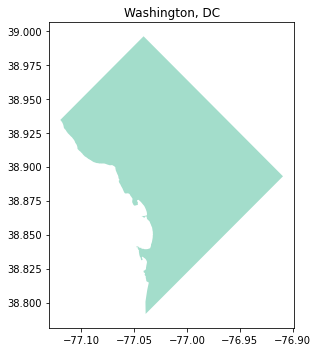

In [5]:
# Create map using DC shapefile
map_data([dc], 'Washington, DC')

It looks like Washington, DC, albeit a bit squished! Next, let’s see how we can work with CRSs in Python.

## Checking and Setting CRSs in Python

### Checking a dataset's coordinate reference system

To check the dataset's CRS, use the `.crs` attribute.

In [6]:
# Get CRS
print('CRS: {}'.format(dc.crs))

CRS: epsg:4326


For our shapefile, the output is a dictionary with a value of `epsg:4326`. We’ll cover what this means in more detail later in this chapter, but just know for now that an `EPSG` code is a way to reference a CRS.

### Change a dataset's CRS

To change a dataset’s CRS, we’ll need to reproject the data. Here, we will project copies of our data twice using the `to_crs()` function, once with a `PROJ.4` string and once with an `EPSG` code. Both of these values reference the same CRS (in this case, NAD83)–they are simply different ways to reference it. The projection will remain in latitude and longitude, but we will change the ellipsoid and datum.

In [7]:
# Example 1: Create a copy of the DC shapefile
dc_reproject_proj4 = dc.copy()

# Reproject the data to NAD83 using PROJ.4 string
dc_reproject_proj4 = dc_reproject_proj4.to_crs('+proj=longlat +ellps=GRS80 +datum=NAD83 +no_defs')

# Example 2: Create a copy of the DC shapefile
dc_reproject_epsg = dc.copy()

# Reproject the data to NAD83 using EPSG code
dc_reproject_epsg = dc_reproject_epsg.to_crs(epsg = 4269)

There are some other formats we can pass as values, but we’ll cover `PROJ.4` string and `EPSG` in this chapter.

When we call the `.crs` attribute, it’s no longer `epsg:4326`, which means that the data has been reprojected!

In [8]:
# Example 1: Print new CRS of DC
print("Example 1 (PROJ.4 string) CRS: {}".format(dc_reproject_proj4.crs))

# Example 2: Print new CRS of DC
print("Example 2 (EPSG code) CRS: {}".format(dc_reproject_epsg.crs))

Example 1 (PROJ.4 string) CRS: +proj=longlat +ellps=GRS80 +datum=NAD83 +no_defs +type=crs
Example 2 (EPSG code) CRS: EPSG:4269


## PROJ.4 String

A `PROJ.4` string identifies and defines a particular CRS. The string holds the parameters (e.g., units, datum) of a given CRS.

### What is in a PROJ.4 String?

Multiple parameters are needed in the string to describe a CRS. To separate the parameters in the string and identify each individual parameter, each parameter begins with a `+` sign. A CRS parameter is defined after the `+` sign.

A few `PROJ.4` parameters can be applied to most CRSs:
| Parameter | Description |
| --- | --- |
| `+a` | Semimajor radius of the ellipsoid axis |
| `+axis` | Axis orientation |
| `+b` | Semiminor radius of the ellipsoid axis |
| `+ellps` | Ellipsoid name |
| `+k_0` | Scaling factor |
| `+lat_0` | Latitude of origin |
| `+lat_1 or 2` | Standard parallels |
| `+lon_0` | Central meridian |
| `+lon_wrap` | Center longitude to use for wrapping |
| `+over` | Allow longitude output outside =180 to 180 range, disables wrapping |
| `+pm` | Alternate prime meridian (typically a city name) |
| `+proj` | Projection name |
| `+units` | meters, US survey feet, etc. |
| `+vunits` | vertical units |
| `+x_0` | False easting |
| `+y_0` | False northing |

Some parameters (not listed above) are specific to certain CRSs. Be sure to always verify the parameters that are allowed for each projection. You can’t always “mix and match” the `PROJ.4` parameters when creating a custom projection.

These parameters can be confusing. To help with this we developed some visual examples.

Take for instance lambert conformal conic with the proj4 string of “+proj=lcc +lat_1=20 +lat_2=60 lon_0=-96 +datum=NAD83 +units=m”. We can see that `lat_1` and `lat_2` specify the standard parallels. This is an example of a “secant” projection which touches the globe in two places in order to minimize distortion. The central meridian `lon_0` is moved away from Greenwich England 96 degrees W to be over roughly Dallas TX.

<p align = 'center'>
    <img src = 'https://pygis.io/_images/d_LambertProj_Code.png'>
</p>

Above is a visualization of lambert conformal conic Proj4 string.

We can look at another example for a UTM projection with the proj4 string of “+proj=tmerc +lon_0=-99 +x_0=500,000 units=m”. This projection by comparison has a central meridian `lon_0` directly over Dallas TX which is 99 degrees W of Greenwich. This central meridan is assigned the ‘false easting’ `x_0` of 500,000 meters.

<p align = 'center'>
    <img src = 'https://pygis.io/_images/d_MercatorProj_Code.png'>
</p>

Above is a visualization of UTM zone 14 Proj4 string.

### Creating a custom CRS using PROJ.4 string

We can change the parameters to create a custom CRS that suits our specific needs. In this section, we will create a CRS tailored to our DC shapefile.

Below is the original shapefile of DC that we read in above–this will serve as a reference point for comparison.

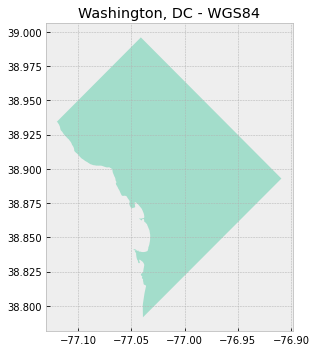

In [9]:
# Map original DC shapefile
map_data([dc], 'Washington, DC - WGS84')

The map above utilizes a geographic coordinate system, as evidenced by the latitude and longitude values on the axes. Another way to check is to look at the geometry of the shapefile.

In [10]:
# Check geometry values of original shapefile
print('Geometry of shapefile:\n{}'.format(dc['geometry'].head()))

Geometry of shapefile:
0    POLYGON ((-77.11980 38.93435, -77.11979 38.934...
Name: geometry, dtype: geometry


#### Reprojecting shapefile to a projected coordinate system

Now, we will reproject the shapefile using a projected coordinate system. Here, we will use the Lambert Conformal Conic projection.

Geometry of shapefile:
0    POLYGON ((1106986.814 4694966.592, 1106987.033...
Name: geometry, dtype: geometry


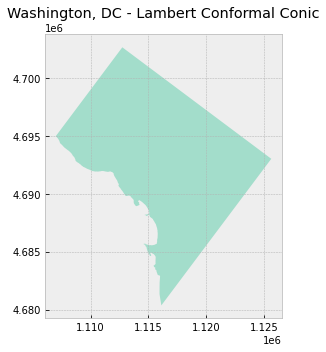

In [11]:
# Create a copy of the DC shapefile
dc_lcc = dc.copy()

# Reproject the data to Lambert Conformal Conic
dc_lcc = dc_lcc.to_crs('+proj=lcc +lon_0=-90 +lat_1=33 +lat_2=45 +ellps=GRS80')

# Map reprojected DC shapefile
map_data([dc_lcc], 'Washington, DC - Lambert Conformal Conic')

# Check geometry values
print('Geometry of shapefile:\n{}'.format(dc_lcc['geometry'].head()))

Notice how the values on the axes changed from latitude and longitude to meters.

#### Setting center point of projection

Also notice how the DC appears to be “tilted” to the left when compared to DC mapped using the previous CRS (WGS84). That’s because the center of this projection is at the 90th meridian west (`+lon_0=-90`; negative is used to denote West) and the Equator (`+lat_0=0`; 0 is the default value when not specified in the `PROJ.4` string).

We can change the values for `lat_0` and `lon_0`, which refer to the latitude of origin and the central meridian, respectively. We will change those values to `38.9072` and `-77.0369`, which is the center of DC.

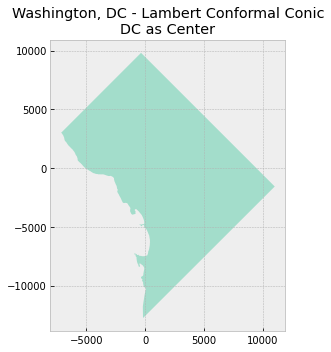

In [12]:
# Create a copy of the DC shapefile
dc_lcc_center = dc.copy()

# Reproject the data to Lambert Conformal Conic with specified center point
dc_lcc_center = dc_lcc_center.to_crs('+proj=lcc +lat_0=38.9072 +lon_0=-77.0369 +lat_1=33 +lat_2=45 +ellps=GRS80')

# Map reprojected DC shapefile
map_data([dc_lcc_center], 'Washington, DC - Lambert Conformal Conic\nDC as Center')

As seen in the new map above, the values on both axes have changed. The origin (0, 0) is now in the center of DC.

#### Setting and exploring standard parallels

The PROJ.4 string for this projection has two additional parameters `lat_1` and `lat_2`, which specify the first and second parallel respectively. Recall that a conic projection “intersects” a globe at what is termed the standard parallels.

Here, we will set our two standard parallels at `38.850` and `39.950` as they fall within the DC boundaries.

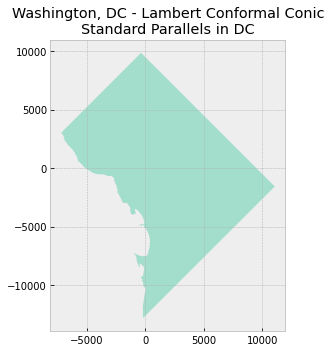

In [13]:
# Create a copy of the DC shapefile
dc_lcc_parallels_1 = dc.copy()

# Reproject the data to Lambert Conformal Conic with specified center point and standard parallels
dc_lcc_parallels_1 = dc_lcc_parallels_1.to_crs('+proj=lcc +lat_0=38.9072 +lon_0=-77.0369 +lat_1=38.850 +lat_2=39.950 +ellps=GRS80')

# Map reprojected DC shapefile
map_data([dc_lcc_parallels_1], 'Washington, DC - Lambert Conformal Conic\nStandard Parallels in DC')

Nothing really appears to be different; however, these values are important. Look what happens when we assign different values–ones that don’t really make sense for mapping in DC–and compare the resulting DC map to the previous map.

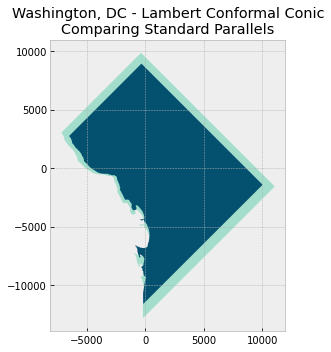

In [14]:
# Create a copy of the DC shapefile
dc_lcc_parallels_2 = dc.copy()

# Reproject the data to Lambert Conformal Conic with specified center point and arbitrary standard parallels
dc_lcc_parallels_2 = dc_lcc_parallels_2.to_crs('+proj=lcc +lat_0=38.9072 +lon_0=-77.0369 +lat_1=10 +lat_2=60 +ellps=GRS80')

# Map reprojected DC shapefile
map_data([dc_lcc_parallels_1, dc_lcc_parallels_2], 'Washington, DC - Lambert Conformal Conic\nComparing Standard Parallels')

It appears DC has shrunk! Of course, that’s not the case in reality, but because map projections are inherently imperfect, choosing arbitrary parameters can make things worse. In this case, since the chosen standard parallels are relatively far from each other and from DC, all the data in between the standard parallels end up being compressed even more.

#### Setting false easting and false northing

Finally, two other parameters we can change are `+x_0` and `+y_0`, which are false easting and false northing respectively. The values assigned to these parameters simply offset the axes by the respective values; they do not change or affect the projection. False easting (with a value of 500,000 m) is used in Universal Tranverse Mercator (UTM) projections so that **negative coordinates are avoided to the west of the central meridian in each zone**. Similarly, false northing (with a value of 10,000,000 m) is also used to **avoid negative coordinates when a UTM zone is in the southern hemisphere**.

Let’s set a false easting value of `500000` and a false northing value of `0`.

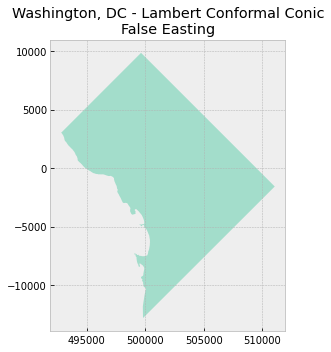

In [15]:
# Create a copy of the DC shapefile
dc_lcc_false_e = dc.copy()

# Reproject the data to Lambert Conformal Conic with specified center point, standard parallels, and false easting/northing
dc_lcc_false_e = dc_lcc_false_e.to_crs('+proj=lcc +lat_0=38.9072 +lon_0=-77.0369 +lat_1=38.850 +lat_2=39.950 +x_0=500000 y_0=0 +ellps=GRS80')

# Map reprojected DC shapefile
map_data([dc_lcc_false_e], 'Washington, DC - Lambert Conformal Conic\nFalse Easting')

Notice that the x-axis shifted to the left by 500,000 meters. The y-axis stayed the same because we did not use false northing. Now, the “origin” is `(500000, 0)`.

#### Comparing custom projection to Universal Tranverse Mercator

UTM is conformal. So let’s compare our custom projection to UTM Zone 18N (in which DC falls).

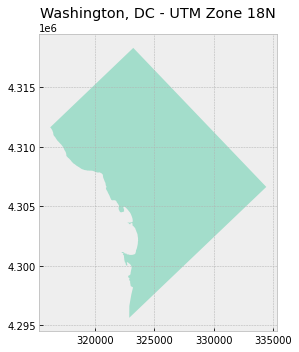

In [16]:
# Create a copy of the DC shapefile
dc_utm18n = dc.copy()

# Reproject the data to UTM Zone 18N
dc_utm18n = dc_utm18n.to_crs('+proj=utm +zone=18 +ellps=WGS84 +datum=WGS84 +units=m +no_defs')

# Map reprojected DC shapefile
map_data([dc_utm18n], 'Washington, DC - UTM Zone 18N')

Looks pretty much the same as our custom one!

## ESPG Code

Many CRSs are assigned and can be referenced by an `EPSG` code, which consists of a four or five digit number. EPSG stands for the European Petroleum Survey Group, a now-defunct organization that compiled this CRS dataset. EPSG codes can be further explored with the EPSG Geodetic Parameter Dataset or at SpatialReference.org.

### Obtaining EPSG code mo PROJ.4 string

Not all CRSs have a corresponding EPSG code, but we can find the `EPSG` code (if it exists) given a `PROJ.4` string. To do so, we can use the `to_espg()` function in the `pyproj` module.

In [17]:
def get_epsg(proj4_string, min_confidence = 70):
    """
    Function takes a PROJ.4 string and optional minimum confidence level as inputs and outputs the relevance EPSG code, if one exists.
    """

    # Get relevant EPSG at the specified minimum confidence level
    return pyproj.CRS(proj4_string).to_epsg(min_confidence = min_confidence)

# Set variable to PROJ.4 string of 83 / California zone 3
proj4_full = "+proj=lcc +lat_1=38.43333333333333 +lat_2=37.06666666666667 +lat_0=36.5 +lon_0=-120.5 +x_0=2000000 +y_0=500000 +ellps=GRS80 +datum=NAD83 +units=m +no_defs"

# Call function to obtain relevant EPSG code
result = get_epsg(proj4_full)

# Print result
print('EPSG code for {}: {}.'.format(proj4_full, result))

EPSG code for +proj=lcc +lat_1=38.43333333333333 +lat_2=37.06666666666667 +lat_0=36.5 +lon_0=-120.5 +x_0=2000000 +y_0=500000 +ellps=GRS80 +datum=NAD83 +units=m +no_defs: 26943.


Success! In the example above, we were able to successfully obtain the `EPSG` code (in this case, `26943` for NAD83 / California zone 3) because it is exactly matched to the `PROJ.4` string. If we’re missing some information in the `PROJ.4` string, however, we might not be able to get an exact `EPSG` code match.

In [18]:
# Set variable to the PROJ.4 string of NAD83 / California zone 3, with a few parameters missing
proj4_missing = "+proj=lcc +lat_1=38.43333333333333 +lat_2=37.06666666666667 +lat_0=36.5 +lon_0=-120.5 +ellps=GRS80 +datum=NAD83 +units=m +no_defs"

# Call function to obtain relevant EPSG code
result_missing = get_epsg(proj4_missing)

# Print result
print("EPSG code for {}: {}.".format(proj4_missing, result_missing))

EPSG code for +proj=lcc +lat_1=38.43333333333333 +lat_2=37.06666666666667 +lat_0=36.5 +lon_0=-120.5 +ellps=GRS80 +datum=NAD83 +units=m +no_defs: None.


#### Lowering minimum confidence parameter

We can lower the min_confidence parameter value in the `to_epsg()` function, which will cause the function to return an `EPSG` code that is the closest match to the provided `PROJ.4` string.

In [19]:
# Call function to obtain releant EPSG code and lower the minimum confidence value
result_lower_confidence = get_epsg(proj4_missing, min_confidence = 20)

# Print result
print('EPSG code for {}: {}'.format(proj4_missing, result_lower_confidence))

EPSG code for +proj=lcc +lat_1=38.43333333333333 +lat_2=37.06666666666667 +lat_0=36.5 +lon_0=-120.5 +ellps=GRS80 +datum=NAD83 +units=m +no_defs: 26943


To get the `PROJ.4` string from an `EPSG` code, we can use the `rasterio` module.

# Affine Transforms

Affine transformations allows us to use simple systems of linear equations to manipulate any point or set of points. It allows us to move, stretch, or even rotate a point or set of points. In the case of GIS, it is used to distort raster data, for instance satellite imagery, to fit a new projection or CRS.

<p align = 'center'>
    <img src = 'https://pygis.io/_images/warp.png'>
</p>

First some general properties of affine transforms:
- **Preserves**:
    - Points, straight linear & planes
    - Sets of parallel lines
    - Ratio of distances between points on same straight line
- **Distorts**:
    - Angle between lines
    - Distance between points

## Types of Transformations

There are four core ways that you can manipulate an image. These are called “Transforms”:

| Transforms | Description | Example |
| --- | --- | --- |
| Translation | Moves a set of points some fixed distance in the x and y plane | 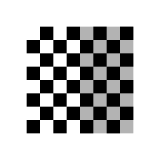 |
| Scale | Increases or decreaes the scale, or distance between points in the x and y plane | 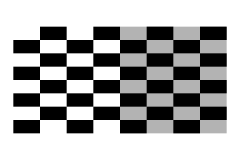 |
| Rotate | Rotates points around the origin, or some defined axis | 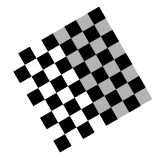 |
| Shear | Shifts points in proportion to any given points x and y coordinate | 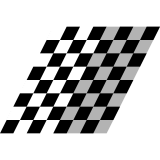 |

In combination we can warp any point, or set of points (e.g. raster image) into a new projection. This is the equivalent of reprojection for vector data. In order to implement these transforms we will need to learn about the math behind *Affine Transforms*! Yeah!

### Simple Transform Examples

To simplify things, first lets think about how to do transformations of a single point in a 2D space.

For any location $ \mathbf{x} = (x, y) $, we can transform $ \mathbf{x} $ to $ \mathbf{\acute{x}} $ using simple linear adjustments. Here we can think of point $ \mathbf{x} $ as being stored as an array:

$$ \mathbf{x} = \begin{bmatrix} x \\ y  \end{bmatrix} \text{can be transformed to } \mathbf{\acute{x}} \begin{bmatrix} \acute{x} \\ \acute{y} \end{bmatrix} $$

From here, we can transform the values in the $x$ and $y$ position using scaler values $\alpha$ through $\mathbf{f}$:

$$ \mathbf{\acute{x}} = \begin{bmatrix} ac + by + c \\ dx + ey + f \end{bmatrix} $$

Looking at the formula above, we are adjusting the value fo $x$ with $ ax + by + c $, so $x$ can be multiplied (scaled) by some value $\alpha$, it can also be scaled based on the $y$ value with $+by$, or simply adjusted up or down by the value $+c$. To understand how this works, let's walk through the basic transformations of $\mathbf{x}$:

If we multiply $x$ and $y$ by one, by setting $ a, e = 1 $, and zero out the effect of the other axis, by setting $ b, d = 0 $, we have a simple case of translation, where $x$ moves right by $c$ and $y$ up by the value of $ \mathbf{f} $:

$$ \mathbf{\acute{x}} = \begin{bmatrix} 1x + 0y + c \\ 0x + 1y + f \end{bmatrix} $$

<p align = 'center'>
    <img src = 'https://pygis.io/_images/translate_coord.png'>
</p>

We can scale $x$ and $y$ by setting $a$ and $e$ to 0.5 (or some fraction), and setting all other values to zero ($ b, d, c, f = 0 $):

$$ \mathbf{\acute{x}} = \begin{bmatrix} ax \\ ey \end{bmatrix} $$

<p align = 'center'>
    <img src = 'https://pygis.io/_images/scale_coord.png'>
</p>

We can rotate a point around the origin by setting $ a, e = cos \theta, b = -sin \theta $ and $ c, f = 0 $:

$$ \mathbf{\acute{x}} = \begin{bmatrix} x cos \theta - y sin \theta \\ x sin \theta + y cos \theta \end{bmatrix} $$

where $\theta$ is the angle of rotation (counterclockwise) around the origin.

<p align = 'center'>
    <img src = 'https://pygis.io/_images/rotate_coord.png'>
</p>

Finally by adjusting $x$ based on the value of $y$ (and vice versa), we can achieve a shear transform:

$$ \mathbf{\acute{x}} = \begin{bmatrix} x + by \\ y + dx \end{bmatrix} $$

<p align = 'center'>
    <img src = 'https://pygis.io/_images/shear_coord.png'>
</p>

### Transforming Matrices

It is often convenient to represent these equation as matrices. This allows us to easily chain together a series of operations. We can represent our transformed point $ \mathbf{\acute{x}} $ as follows:

$$ \begin{bmatrix} \acute{x} \\ \acute{y} \end{bmatrix} = \begin{bmatrix} ax + by \\ dx + ey \end{bmatrix} = \begin{bmatrix} a & b \\ d & e \end{bmatrix} \begin{bmatrix} x \\ y \end{bmatrix} $$

In this new context we can easily do a scale, rotate, or shear transform by replacing the matrix of $a, b, d, e$ with:

$$ \text{Rotate: } \begin{bmatrix} cos \theta & -sin \theta \\ sin \theta & cos \theta \end{bmatrix} $$
$$ \text{Scale: } \begin{bmatrix} S_x & 0 \\ 0 & S_y \end{bmatrix} $$
$$ \text{Shear: } \begin{bmatrix} 1 & r_x \\ r_y & 1 \end{bmatrix} $$

*But wait, what about the easiest transform, “translation”?* Unfortunately that makes things a little more complicated! But not that complicated.

In order to be able to perform a translate in matrix form we need to extend our matrices, adding one row along the bottom. In the following form we can now perform all the basic transformations to calculate $ \mathbf{\acute{x}} $:

$$ \begin{bmatrix} \acute{x} \\ \acute{y} \\ 1  \end{bmatrix} = \begin{bmatrix} a & b & c \\ d & e & f \\ 0 & 0 & 1  \end{bmatrix} \begin{bmatrix} x \\ y \\ 1 \end{bmatrix} = \begin{bmatrix} ax + by + c \\ dx + ey + f \\ 1  \end{bmatrix} $$

Now that we have scalers $c$ and $f$, all transforms are possible. We do however need to update our previous operations:

$$ \text{Translate: } \begin{bmatrix} 1 & 0 & \Delta x \\ 0 & 1 & \Delta y \\ 0 & 0 & 1 \end{bmatrix} $$

Where the $ \Delta x $ shifts in the $x$ axis and $\Delta y $ determines the shift in the $y$ axis.

$$ \text{Rotate: } \begin{bmatrix} cos \theta & -sin \theta & 0 \\ sin \theta & cos \theta & 0 \\ 0 & 0 & 1 \end{bmatrix} $$
$$ \text{Scale: } \begin{bmatrix} S_x & 0 & 0 \\ 0 & S_y & 0  \\ 0 & 0 & 1 \end{bmatrix} $$
$$ \text{Shear: } \begin{bmatrix} 1 & r_x & 0 \\ r_y & 1 & 0 \\ 0 & 0 & 1 \end{bmatrix} $$

### Numeric Examples

#### Translate

Now let’s assume we have a point $a$ at (-2,-2) for $(x,y)$. For simplicity sake, let's assume we want to move it up to the origin by adding 2 to both $x$ and $y$.

Let’s start by defining our point in our matrix form:

$$ \begin{bmatrix} x \\ y \\ 1  \end{bmatrix} = \begin{bmatrix} -2 \\ -2 \\ 1  \end{bmatrix} $$

Let's get our transform matrix $M$ to perform our translate, where $ \Delta x, \Delta y = 2 $ because we want to move it up and to the right:

$$ \begin{bmatrix} 1 & 0 & 2 \\ 0 & 1 & 2 \\ 0 & 0 & 1 \end{bmatrix} $$

We can then multiply the two: 

$$ \begin{bmatrix} -2 \\ -2 \\ 1  \end{bmatrix} \begin{bmatrix} 1 & 0 & 2 \\ 0 & 1 & 2 \\ 0 & 0 & 1 \end{bmatrix} = \begin{bmatrix} -2 \times 1 + -2 \times 0 + 1 \times 2 \\ -2 \times 0 + -2 \times 1 + 1 \times 2 \\ -2 \times 0 + -2 \times 0 + 1 \times 1 \end{bmatrix} = \begin{bmatrix} 0 \\ 0 \\ 1 \end{bmatrix} $$

Congrats, we reached (0, 0)! Remember the bottom row can be ignored because $ \begin{bmatrix} x \\ y \\ 1 \end{bmatrix} $

<p align = 'center'>
    ,<img src = 'https://pygis.io/_images/translate_ex.png'>
</p>

#### Rotate

All the transformations follow the same procedure, let’s try rotation just to make sure that we have it figured out. Let’s rotate our point at (-2,-2) by 180 degrees around the origin:

$$ \begin{bmatrix} -2 \\ -2 \\ 1  \end{bmatrix} \begin{bmatrix} cos 180 & -sin 180 & 0 \\ sin 180 & cos 180 & 0 \\ 0 & 0 & 1 \end{bmatrix} = \begin{bmatrix} -2 \times cos 180 + -2 \times -sin 180 + 1 \times 0 \\ -2\times sin 180 +  -2 \times cos 180 + 1 \times 0 \\ 1 \times 0 + 1 \times 0 + 1 \times 1 \end{bmatrix} = \begin{bmatrix}  2 \\ 2 \\ 1 \end{bmatrix} $$

<p align = 'center'>
    <img src = 'https://pygis.io/_images/rotate_ex.png'>
</p>

# Vector Coordinate Reference Systems

When it comes to coordinate reference systems points, lines and polygons are convenient because each point or node has an assigned coordinate pair (x,y). The only trick then is to know how those coordinates relate to the coordinate space, or location on the ground.

## Define a Projection for Points, Lines, Polygons

When a point, line, or polyon is created, each point or node has two coordinates `x` and `y`. The location of these two points on the ground will change wildly between projections. The coordinate pair (0, 0) might mean a location just off shore from Ghana with WGS84 LatLon, or in the middle of the Pacific ocean in another.

Let’s take a look at the example of a polygon with coordinates (0, 45), (5,45), (5, 40),(0, 40) below. In the left pane we can see that, although we have the polygon’s node coordinates, we don’t know where they are located! This is because no coordinate reference system has been assigned to it. Could be in outer space for all we know. On the right, we can see that we have assigned it WGS84 geographic lat lon i.e. `EPSG:4326`. Suddenly the coordinates make sense, because we know how they relate to locations on the ground.

<p align = 'center'>
    <img src = 'https://pygis.io/_images/d_crs_assigned.png'>
</p>

Every time we create vector data (or receive it from someone else), we need to make sure that a projection is assigned to it. The following demonstrates how to:

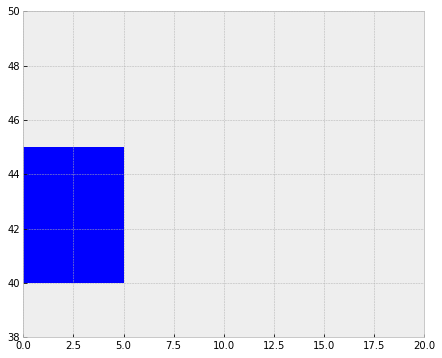

In [20]:
plt.style.use('bmh')

a_square = {
    'name': ['Washington\n(38.90, -77.03)'],
    'geometry': [Polygon([(0, 45), (5, 45), (5, 40), (0, 40)])]
}

# Create a DataFrame from the nodes and assign the CRS
gdf_square = gpd.GeoDataFrame(a_square, crs = 'EPSG:4326')

fig, ax = plt.subplots(figsize = (12, 6))
gdf_square.plot(ax = ax, color = 'blue')
plt.ylim(38, 50)
plt.xlim(0, 20)
plt.show()

## Reproject Points, Lines, Polygons

Once a projection is assigned we often have to ‘reproject’ it to another one. Reprojection entails **using a set of formulas to convert (x,y) stored in latitude and longitude into another coordinate space**. This entails a two-step process.

Looking at the example below, we will move from Sinosoidal to Hobo-Dyer. The first step however is to **use the “inverse equation” to convert coordinate pairs from Sinosoidal back to lat lon**, and the **use the forward equation to convert lat lon into the Hobo-Dyer coordinate space**.

<p align = 'center'>
    <img src = 'https://pygis.io/_images/d_reprojection_example.jpg'>
</p>

These ‘forward’ and ‘inverse’ equations can be simple or complex. To make things easy to understand lets look at the example of reprojecting from proj4 code `+proj=longlat +datum=WGS84` to `+proj=longlat +datum=WGS84 +lon_0=-10`, where `+lon_0=-10` just moves the prime meridian 10 degrees west (west is negative). Because we are already in latitude and longitude we can ignore the ‘inverse’ equation and just look at the ‘forward’ equation.

In this case the ‘forward’ equation is very simple:

$$x = x + 10$$
$$y = y $$

As a result, the polygon remains in the same location, but in the 'new' projection, longitude values are now all 10 degrees higher.

<p align = 'center'>
    <img src = 'https://pygis.io/_images/d_europe_translate_vector.png'>
</p>

Most ‘forward’ and ‘inverse’ equations are non-linear and more complex. Take for instance the Gall-Peters forward projection equations are shown below:

$$ x = \frac{R \pi \lambda cos 45^{\circ}}{180^{\circ}} $$
$$ y = \frac{R sin \varphi}{cos 45^{\circ}} $$

where $\lambda$ is the longitude from the central meridian in degrees, $\varphi$ is the latitude, and R is the radius of the globwe used as the model of the earth for projection.

Referring back to our previous example, let's use geopandas to move the prime meridian 10 degrees west:

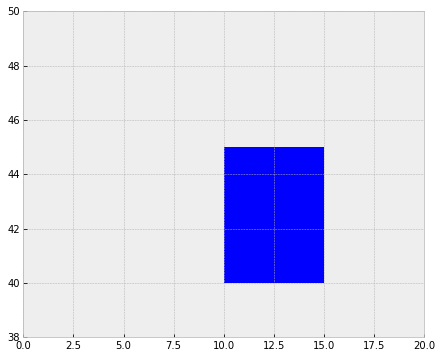

In [22]:
# Reproject the data
gdf_square_10w = gdf_square.to_crs('+proj=longlat +datum=WGS84 +lon_0=-10')

fig, ax = plt.subplots(figsize = (12, 6))
gdf_square_10w.plot(ax = ax)
plt.ylim(38, 50)
plt.xlim(0, 20)
plt.show()

Note the shift in coordinates along $x$ by 10 degrees west.

# Raster Coordinate Reference Systems

Raster data is very different that vector data, one of the key differences is that **we don’t have a pair of coordinates (x,y) for each pixel** in a raster. How then do we know where the raster is located in addition to what the data values are? For a new spatial raster (e.g. geotif) we need to store a few other pieces of information seperately. We need to keep track of the **location of the upper left hand corner**, the **resolution (in both the x and y direction)** and a **description of the coordinate space** (i.e. the CRS), amongst others.

Let’s start from the `ndarray` `Z` that we want to span from [-90°, 90°] longitude, and [-90°, 90°] latitude.

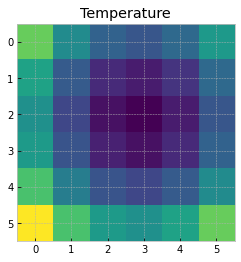

In [23]:
x = np.linspace(-90, 90, 6)
y = np.linspace(90, -90, 6)
X, Y = np.meshgrid(x, y)

Z1 =  np.abs(((X - 10) ** 2 + (Y - 10) ** 2) / 1 ** 2)
Z2 =  np.abs(((X + 10) ** 2 + (Y + 10) ** 2) / 2.5 ** 2)
Z =  (Z1 - Z2)

plt.imshow(Z)
plt.title("Temperature")
plt.show()

Note that `Z` contains *no data on its location*. Its just an array, the information stored in x and y aren’t associated with it at all. This location data will often be stored in the header of file. In order to ‘locate’ the array on the map we will use **affine transformations**.

Affine transformations allows us to use simple systems of linear equations to **manipulate any point or set of points**. It allows us to move, stretch, or even rotate a point or set of points. In the case of GIS, it is **used to move raster data, a satellite image, to the correct location in the CRS coordinate space**.

## Describing the Array Location (Define a Projection)

In this example, the coordinate reference system will be `+proj=latlong`, which describes an equirectangular coordinate reference system with units of decimal degrees. Although `X` and `Y` seems relevant to understanding the location of cell values, rasterio instead uses affine transformations instead. Affine transforms uses **matrix algebra to describe where a cell is located (translation) and what its resolution is (scale)**. 

The affine transformation matrix can be computed from the matrix product of a translation (moving N, S ,E, W) and a scaling (resolution). First, we start with translation where $\Delta x$ and $\Delta y$ define the location of the upper left hand corner of our new `Z` ndarray. As a reminder the translation matrix takes the form:

$$ \text{Translate: } \begin{bmatrix} 1 & 0 & \Delta x \\ 0 & 1 & \Delta y \\ 0 & 0 & 1 \end{bmatrix} $$

Now we can define our translation matrix using the point coordinates (`x[0], y[0]`), but these need to be offset by 1/2 the resolution so that the cell is centered over the coordinate (-90,90). Notice however there are some difference between the x and y resolution:

In [24]:
xres = (x[-1] - x[0]) / len(x)
xres

30.0

But notice that the y resolution is **negative**:

In [25]:
yres = (y[-1] - y[0]) / len(y)
yres

-30.0

We need to create our translation matrix by defining the location of the upper left hand corner. Looking back at our definitions, of our coordinates `X` and `Y` we can see that they are defined with `x = np.linspace(-90, 90, 6)`; `y = np.linspace(90, -90, 6)`; `X, Y = np.meshgrid(x, y)`, if you run `print(X)`; `print(Y)` you will see that the center of the upper left hand corner should be located at (-90, 90). The upper left hand corner of that same cell is actually further up and to the left than (-90, 90). It follows then that that corner should be shifted exactly 1/2 the resolution of the cell, both up and to the left.

We can therefore define the upper left hand corner by setting $ \Delta x = x[0] - \frac{xres}{2} $ and $ \Delta y = y[0] - \frac{yres}{2} $. Remember yres is negative, so subtraction is correct.

In [30]:
x

array([-90., -54., -18.,  18.,  54.,  90.])

In [32]:
y

array([ 90.,  54.,  18., -18., -54., -90.])

In [28]:
print(Affine.translation(x[0] - xres / 2, y[0] - yres / 2))

| 1.00, 0.00,-105.00|
| 0.00, 1.00, 105.00|
| 0.00, 0.00, 1.00|


We also need to scale our data based on the resolution of each cell. The scale matrix takes the following form:

$$ \text{Scale: } \begin{bmatrix} xres & 0 & 0 \\ 0 & yres & 0 \\ 0 & 0 & 1 \end{bmatrix} $$

In [29]:
print(Affine.scale(xres, yres))

| 30.00, 0.00, 0.00|
| 0.00,-30.00, 0.00|
| 0.00, 0.00, 1.00|


We can do both operations simultaneously in a new `transform` matrix by calculating the product of the Translate and Scale matrices:

$$ \text{Translate} \cdot \text{Scale} = \begin{bmatrix} xres & 0 & \Delta x \\ 0 & yres & \Delta y \\ 0 & 0 & 1 \end{bmatrix} $$

In [33]:
transform = Affine.translation(x[0] - xres / 2, y[0] - yres / 2) * Affine.scale(xres, yres)
print(transform)

| 30.00, 0.00,-105.00|
| 0.00,-30.00, 105.00|
| 0.00, 0.00, 1.00|


Now we need to write out a `tif` file that holds the data in `Z` and its data type with `dtype`, the location described by `transform`, in coordinates described by the coordinate reference system `+proj=latlon`, the number of ‘bands’ of data in `count` (in this case just one), and the shape in `height` and `width`.

In [36]:
with rasterio.open(
    os.getcwd() + '/data/Z.tif',
    'w',
    driver = 'GTiff',
    height = Z.shape[0],
    width = Z.shape[1],
    count = 1,
    dtype = Z.dtype,
    crs = '+proj=latlong',
    transform = transform,
) as dst:
    dst.write(Z, 1)

All this info is stored in `dst` and then written to disk with `dst.write(Z, 1)`. Where write gets the array of data `Z` and the band location to write to, in this case band `1`. This is a bit awkward, but is just a carryover from GDAL which rasterio relies on heavily (like all other platforms including arcmap etc).

### The Crazy Tale of the Upper Left Hand Corner

To help us understand what is going on with `transform`, it helps to work an example. For our example above, we need to define the translate matrix that helps define the upper left hand corner of our rainfall raster data `Z`. In particular we need the upper left cell center to be located at (-90,90), so the upper left hand corner need to be 1/2 the resolution above and to the left of (-90,90), implying a location of (-105,105) since the resolution is 25 degrees.

We can visualize what we need to do here:

<p align = 'center'>
    <img src = 'https://pygis.io/_images/c_raster_upperleft_drawing.png'>
</p>

Let's walk through the math behind the scenes. Here, we use our transform matrix o move our upper left hand corner which is assumed to start at the origin (0, 0).

<p align = 'center'>
    <img src = 'https://pygis.io/_images/c_raster_upperleft_transform.png'>
</p>

The final coordinate of the upper left hand corner is $ (x_0, y_0) = (-105, 105) $.

### Translate is a "map"

Now here’s the magic, our new `translate` matrix can be used to easily find the coordinates of any cell based on its row and column number. To see how if works, we are going to multiply our `translate` matrix by (`column_number`, `row_number`) to retrieve the coordinates of that cell’s upper right hand corner. Essentially, `translate` “maps” row and column indexes to coordinates!

Let’s see how we can calculate a few coordinates (upper left) based on the visual examples below:

<p align = 'center'>
    <img src = 'https://pygis.io/_images/c_raster_raster.png'>
</p>

Let’s start with the easiest and retrieve the upper left corner coordinates based on `transform` * (`row_number`, `column_number`):

In [37]:
print(transform * (0, 0))

(-105.0, 105.0)


Let's find that corner that is one cell down (-30 $^{\circ}$) and to the right (+30 $^{\circ}$).

In [38]:
print(transform * (1, 1))

(-75.0, 75.0)


Just to make sure it works, let's find a harder one. 5th column to the right, 2nd row down.

In [39]:
print(transform * (5, 2))

(45.0, 45.0)


Let's work the example of finding the upper left coordinates of with `row = 5`, `column = 2`:

$$ \begin{bmatrix} 5 \\ 2 \\ 1 \end{bmatrix} \begin{bmatrix} 30 & 0 & -105 \\ 0 & -30 & 105 \\ 0 & 0 & 1 \end{bmatrix}  = \begin{bmatrix} 5 \times 30 + 2 \times 0 + 1 \times -105 \\ 5 \times 0 + 2 \times -30 + 1 \times 105 \\ 5 \times 0 + 2 \times = + 1 \times 1 \end{bmatrix} = \begin{bmatrix} 45 \\ 45 \\ 1 \end{bmatrix} $$

It works!

## Reproject a Raster - The Simple Case

How then do we reproject a raster? Since transform is a map of pixel locations, warping a raster then becomes as simple as **knowing the transform of your destination based on the description of the new coordinate reference system (CRS)**.

### Shifting the Prime Meridian

One of the easiest cases is that of **false easting**, or moving the prime meridian. Let’s walk through an example where we start with a raster with an upper left hand corner at (0, 45), then we will apply a transform to move it to (10, 45) by moving the prime meridian 10° to the west (e.g. using `+lon_0=-10` from the proj4string).

Let’s start be looking visually at what we plan to do:

<p align = 'center'>
    <img src = 'https://pygis.io/_images/d_europe_translate_raster.png'>
</p>

We can then use our knowledge of matrix algebra and transform matrices to solve for the new upper left hand corner coordinate ($ x_B, y_B $).

<p align = 'center'>
    <img src = 'https://pygis.io/_images/d_europe_translate_raster_m.png'>
</p>

## Reproject a Raster - The Complex Case

In many cases, reprojecting a raster requires **changing the number of rows or columns**, or **‘warping’** (i.e. bending) an image. All of these examples create a problem, the centroids of the new projected raster don’t line up with the centroids of the original raster. Therefore they now represent locations on the ground that weren’t in the original dataset.

Take for instance the case of a ‘warped’ raster image (below) which for instance occurs when you switch from a spherical CRS (like lat lon) to a projected (or flat) CRS. Notice that the centroids of the two rasters no longer overlap:

<p align = 'center'>
    <img src = 'https://pygis.io/_images/d_warp.png'>
</p>

In this case we have a decision to make, how will we assign values to the new warped raster? Keep in mind the values must change because they now point to different locations on the ground. For this we have a number of ‘interpolation’ options, some simple, some complex.

### Interpolation Options

There are three commonly used interpolation methods:
1. **Nearest neighbor** - assigns the value of the **nearest centroid**,
2. **Bilinear interpolation** - uses a **straight line between known locations**, and
3. **Bicubic interpolation** - uses **curved line between known locations**.

In the visual example below, we will try to estimate the value for location `C` based on the known values at locations `A` and `B`.

<p align = 'center'>
    <img src = 'https://pygis.io/_images/d_bilinear.png'>
</p>
<p align = 'center'>
    <img src = 'https://pygis.io/_images/d_bicubic.png'>
</p>

### Choosing the Right Interpolation Method

Choosing the correct interpolation method is important. The following table should help you to decided. Remember categorical data might include land cover classes (forest, water, etc), and continuous data is measurable for instance rainfall (values 0 to 20mm).

| Method | Description | Fast | Categorical | Continuous |
| --- | --- | --- | --- | --- |
| Nearest Neighbor | Assigns nearest value | Y | Y |   |
| Bilinear | Linear estimation | Y |   | Y |
| Bicubic | Non-linear estimation | Most of the time |   | Y |

For *categorical data*, **Nearest Neighbor** is your only choice, enjoy it. For *continuous data*, like quantity of rain, you can choose between **Bilinear** and **Bicubic** (i.e. “cubic convolution”). For most data, Bilinear interpolation is fast and effective. However if you believe your data is highly non-linear, or widely spaced, you might consider using Bicubic. Some experimentation here is often informative.

## Reprojecting a Raster with Rasterio

Ok enough talk already, how do we reproject a raster? Before we get into it, we need to talk some more… about `calculate_default_transform`. `calculate_default_transform` allows us to generate the transform matrix required for the new reprojected raster based on the characteristics of the original and the desired output CRS. Note that the `source` (src) is the original input raster, and the `destination` (dst) is the outputed reprojected raster.

First, remember that the transform matrix takes the following form:

$$ \text{Transform} = \begin{bmatrix} xres & 0 & \Delta x \\ 0 & yres & \Delta y \\ 0 & 0 & 1 \end{bmatrix} $$

Now let's calculate the transform matrix for the destination raster:

In [46]:
dst_crs = 'EPSG:3857' # web mercator (i.e. google maps)

with rasterio.open(os.getcwd() + '/data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF') as src:
    # Transform for input raster
    src_transform = src.transform

    # Calculate the transform matix for the output
    dst_transform, width, height = calculate_default_transform(
        src.crs,        # Source CRS
        dst_crs,        # Destination CRS
        src.width,      # Column count
        src.height,      # Row count
        *src.bounds,    # Unpacks outer boundaries (left, bottom, right, top)
    )

print('Source Transform:\n', src_transform, '\n')
print('Destination Transform:\n', dst_transform)

Source Transform:
 | 30.00, 0.00, 717345.00|
| 0.00,-30.00,-2776995.00|
| 0.00, 0.00, 1.00| 

Destination Transform:
 | 33.24, 0.00,-6105300.09|
| 0.00,-33.24,-2885952.71|
| 0.00, 0.00, 1.00|


Notice that in order to keep the same number of rows and columns that the resolution of the destination raster increased from 30 meteres to 33.24 meters. Also, the coordiantes of the upper left hand corner have shifted (check $ \Delta x, \Delta y $).

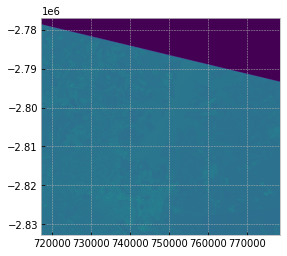

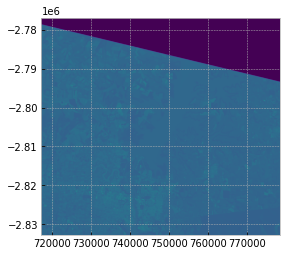

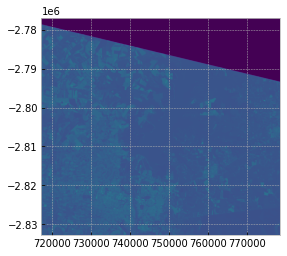

In [56]:
st_crs = 'EPSG:3857' # web mercator (i.e. google maps)

with rasterio.open(os.getcwd() + '/data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF') as src:
    # Transform for input raster
    src_transform = src.transform

    # Calculate the transform matix for the output
    dst_transform, width, height = calculate_default_transform(
        src.crs,        # Source CRS
        dst_crs,        # Destination CRS
        src.width,      # Column count
        src.height,      # Row count
        *src.bounds,    # Unpacks outer boundaries (left, bottom, right, top)
    )

    # Set properties for output
    dst_kwargs = src.meta.copy()
    dst_kwargs.update(
        {
            'crs': dst_crs,
            'transform': dst_transform,
            'width': width,
            'height': height,
            'nodata': 0, # Replace 0 with np.nan
        }
    )

    with rasterio.open(os.getcwd() + '/data/LC08_20200518_webMC.tif', 'w', **dst_kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source = rasterio.band(src, i),
                destination = rasterio.band(dst, i),
                src_transform = src.transform,
                src_crs = src.crs,
                dst_transform = dst_transform,
                resampling = Resampling.nearest,
            )
    
            show((src, i))

In [59]:
raster = rasterio.open(os.getcwd() + '/data/LC08_20200518_webMC.tif')
raster.count

3

In [60]:
red = raster.read(3)
green = raster.read(2)
blue = raster.read(1)

def normalize(array):
    """
    Normalizes numpy arraysinto scale 0.0 - 1.0
    """
    array_min, array_max = array.min(), array.max()
    return ((array - array_min) / (array_max - array_min))

In [61]:
# Normalize the bands
redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)

# Normalize the bands
redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)

print("Normalized bands")
print(redn.min(), '-', redn.max(), 'mean:', redn.mean())
print(greenn.min(), '-', greenn.max(), 'mean:', greenn.mean())
print(bluen.min(), '-', bluen.max(), 'mean:', bluen.mean())

Normalized bands
0.0 - 1.0 mean: 0.2262263600911267
0.0 - 1.0 mean: 0.2721202368032239
0.0 - 1.0 mean: 0.310770707111992


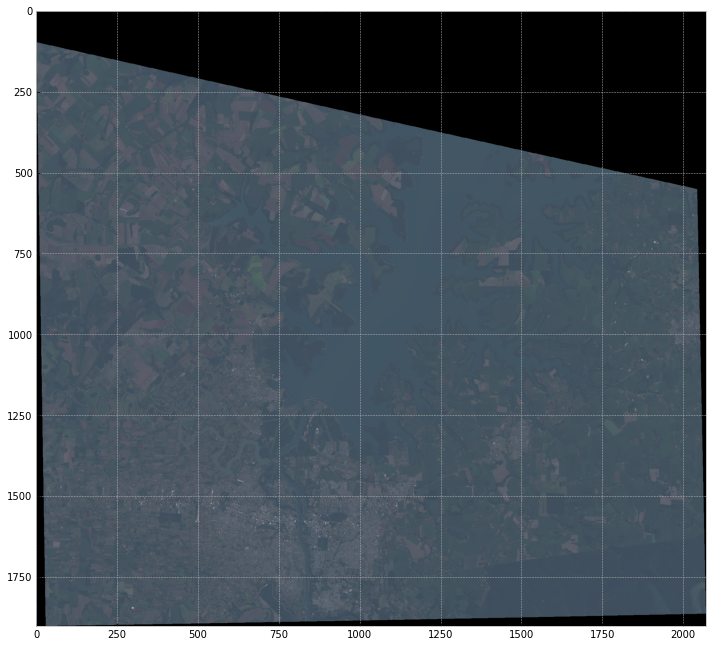

In [64]:
# Create RGB natural color composite
rgb = np.dstack((redn, greenn, bluen))

# Let's see how our color composite looks like
plt.figure(figsize = (12, 12))
plt.imshow(rgb)
plt.show()

<p align = 'center'>
    <img src = 'https://pygis.io/_images/d_reproj_image.png'>
</p>
This is the reprojected Landsat image